In [ ]:
import itertools
import torch
import torch.utils.data
import dataset
import datasetloader
import importlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import models 
from torch.autograd import Variable
from utils import *
class Opt(object):
    def __init__(self):
        return
opt = Opt()

In [4]:
#importlib.reload(dataset)
opt.device = 'cuda:0' #opt0: device
opt.dataset = 'mini'
opt.train_dir = 'train'
opt.data_dir = './datasets/'
opt.batch_size = 1
opt.size = 256

dataset = dataset.Dataset(opt)
Img = dataset.__getitem__(1)
Img

{'A': tensor([[[ 0.3098,  0.3098,  0.3020,  ...,  0.5686,  0.5059,  0.4824],
          [ 0.2941,  0.2941,  0.2941,  ...,  0.5686,  0.5137,  0.4588],
          [ 0.3020,  0.3020,  0.2941,  ...,  0.5686,  0.5294,  0.4588],
          ...,
          [-0.6549, -0.6314, -0.6471,  ..., -0.6235, -0.5922, -0.5922],
          [-0.6392, -0.6314, -0.6392,  ..., -0.5922, -0.5922, -0.6078],
          [-0.6471, -0.6392, -0.6314,  ..., -0.5843, -0.5843, -0.6157]],
 
         [[ 0.5529,  0.5451,  0.5373,  ...,  0.5137,  0.4824,  0.4667],
          [ 0.5451,  0.5373,  0.5373,  ...,  0.5216,  0.4980,  0.4588],
          [ 0.5529,  0.5451,  0.5451,  ...,  0.5294,  0.5059,  0.4667],
          ...,
          [-0.6627, -0.6471, -0.6549,  ..., -0.6235, -0.6000, -0.5843],
          [-0.6471, -0.6314, -0.6471,  ..., -0.6078, -0.5843, -0.6000],
          [-0.6314, -0.6314, -0.6314,  ..., -0.5922, -0.5765, -0.5922]],
 
         [[ 0.8902,  0.8745,  0.8667,  ...,  0.6235,  0.5922,  0.5843],
          [ 0.8980,  0.

In [7]:
###### Definition of variables ######
# Networks
#importlib.reload(utils.py)
opt.A_nc =3
opt.B_nc = 3
opt.cuda = 1
opt.lr = 0.0002
opt.epoch_count = 0
opt.n_epochs = 100 
opt.n_epochs_decay = 100 
netG_A2B = models.CycleGenerator(opt.A_nc, opt.B_nc)
netG_B2A = models.CycleGenerator(opt.B_nc, opt.A_nc)
netD_A = models.CycleDiscriminator(opt.A_nc)
netD_B = models.CycleDiscriminator(opt.B_nc)

if opt.cuda:
    netG_A2B.to(opt.device)
    netG_B2A.to(opt.device)
    netD_A.to(opt.device)
    netD_B.to(opt.device)


    
netG_A2B.apply(models.weights_init)
netG_B2A.apply(models.weights_init)
netD_A.apply(models.weights_init)
netD_B.apply(models.weights_init)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt).lambda_rule)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt).lambda_rule)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt).lambda_rule)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batch_size, opt.A_nc, opt.size, opt.size)
input_B = Tensor(opt.batch_size, opt.B_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batch_size).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batch_size).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Loda data
data_loader = datasetloader.DatasetLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(dataset)
# Loss plot
logger = Logger(opt.n_epochs + opt.n_epochs_decay, dataset_size)
#for i, j in enumerate(dataset):
#    print(j)
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay):
    for i, batch in enumerate(dataset):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # Progress report (http://localhost:8097)
        logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                   # 'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
                   # images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    
    print("epoch:", epoch, 'loss_G_cycle:', (loss_cycle_ABA + loss_cycle_BAB))
    #plt.figure(1)
    #plt.subplot(1,2,1)
    #plt.imshow(tensor2image2(real_A))
    #plt.subplot(1,2,2)
    #plt.imshow(tensor2image2(fake_B))

    # Save models checkpoints
    #torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
    #torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
    #torch.save(netD_A.state_dict(), 'output/netD_A.pth')
    #torch.save(netD_B.state_dict(), 'output/netD_B.pth')
###################################

dataset [Dataset] was created


/root/Anacondas/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss_G_cycle: tensor(5.3167, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 1 loss_G_cycle: tensor(7.3748, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 2 loss_G_cycle: tensor(7.8085, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 3 loss_G_cycle: tensor(4.3416, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 4 loss_G_cycle: tensor(7.1166, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 5 loss_G_cycle: tensor(8.0725, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 6 loss_G_cycle: tensor(7.8204, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 7 loss_G_cycle: tensor(3.9844, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 8 loss_G_cycle: tensor(6.0597, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 9 loss_G_cycle: tensor(4.3274, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 10 loss_G_cycle: tensor(5.0857, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 11 loss_G_cycle: tensor(5.8409, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 12 loss_G_cycle: tensor(3.7934, device='cud

epoch: 103 loss_G_cycle: tensor(3.0360, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 104 loss_G_cycle: tensor(3.2491, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 105 loss_G_cycle: tensor(2.3753, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 106 loss_G_cycle: tensor(3.0656, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 107 loss_G_cycle: tensor(3.5272, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 108 loss_G_cycle: tensor(4.2506, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 109 loss_G_cycle: tensor(5.1147, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 110 loss_G_cycle: tensor(3.4849, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 111 loss_G_cycle: tensor(3.4482, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 112 loss_G_cycle: tensor(5.3308, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 113 loss_G_cycle: tensor(4.4056, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 114 loss_G_cycle: tensor(3.3536, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 115 loss_G_cycle: ten

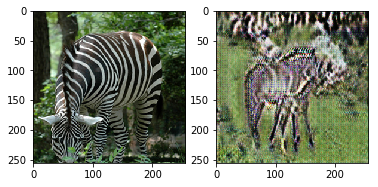

In [10]:
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(tensor2image2(real_B))
plt.subplot(1,2,2)
plt.imshow(tensor2image2(fake_B))

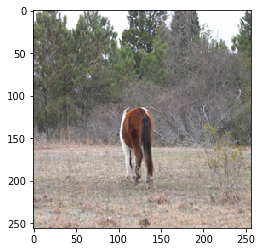

In [22]:
plt.imshow(real_A)